
**Student of EVA7 Batch awaiting EVA Phase II submitting EVA8 Transformer Assignments** </br>
Repository github url : https://github.com/jai-mr/Session </br>
Assignment Repository : https://github.com/jai-mr/Session/blob/main/S13/README.md</br>
Submitted by : Jaideep R - No Partners</br>
Registered email id : jaideepmr@gmail.com</br>

**Objective:***</br>

A. train your own UNet from scratch</br>
B. using the dataset https://www.kaggle.com/tanlikesmath/the-oxfordiiit-pet-dataset </br>
C. strategy provided in this link https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406</br>
D. train it 4 times:</br>
i. MP+Tr+BCE</br>
ii. MP+Tr+Dice Loss</br>
iii. StrConv+Tr+BCE</br>
iv. StrConv+Ups+Dice Loss</br>

In [1]:
# Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)
gdrivepath="/content/gdrive/MyDrive/EVA8/s13/unet"
%cd /content/gdrive/MyDrive/EVA8/s13/unet

Mounted at /content/gdrive
/content/gdrive/MyDrive/EVA8/s13/unet


In [2]:
%pwd

'/content/gdrive/MyDrive/EVA8/s13/unet'

In [ ]:
!nvidia-smi

Fri Apr 21 15:27:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!mkdir './OxfordIIITPet'
!wget -q http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget -q http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
%mkdir OxfordIIITPet

In [ ]:
!tar -xf images.tar.gz

In [ ]:
!tar -xf annotations.tar.gz

In [ ]:
!mv images ./OxfordIIITPet

In [ ]:
!mv annotations ./OxfordIIITPet

In [ ]:
%ls OxfordIIITPet/images |wc -l

In [3]:
%ls OxfordIIITPet/annotations/trimaps|wc -l

7390


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader
import torchvision.transforms.functional as TF
import numpy as np
import cv2
import PIL
import math
from PIL import Image as img
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import albumentations as A
cuda = torch.cuda.is_available()
import datetime
import os

In [5]:
# define transform to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor()
])

# define custom dataset class
class OxfordPetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.loader = default_loader
        self.mask_path = 'OxfordIIITPet/annotations/trimaps/'
        
        self.image_paths, self.labels = self._get_paths_and_labels()
        
    def _get_paths_and_labels(self):
        annotation_path = os.path.join(self.root_dir, 'annotations', 'list.txt')
        with open(annotation_path) as f:
            lines = f.readlines()
        image_paths = []
        labels = []
        for line in lines:
            if line[0] == '#':
                pass
            else:                
                image_path, label, species, breed = line.strip().split(' ')
                image_paths.append(os.path.join(self.root_dir, 'images', image_path + '.jpg'))
                labels.append(int(label) - 1)  # convert labels to 0-based indexing
        
        # split the dataset into train and test sets
        n_samples = len(image_paths)
        indices = list(range(n_samples))
        split_idx = int(np.floor(0.2 * n_samples))
        np.random.shuffle(indices)
        if self.split == 'train':
            indices = indices[split_idx:]
        else:
            indices = indices[:split_idx]
        image_paths = [image_paths[i] for i in indices]
        labels = [labels[i] for i in indices]
        return image_paths, labels
        
    def __getitem__(self, index):
        # load image and label
        image_path = self.image_paths[index]
        trimap_path = self.mask_path + image_path.split('/')[-1].split('.')[0] + '.png'
        image = self.loader(image_path)        
        label = self.labels[index]
        
        # apply transform to image
        if self.transform is not None:
            image = self.transform(image)
       
        return image, label, trimap_path
        
    def __len__(self):
        return len(self.image_paths)

# create train and test datasets
train_dataset = OxfordPetDataset(root_dir='OxfordIIITPet', split='train', transform=transform)
test_dataset = OxfordPetDataset(root_dir='OxfordIIITPet', split='test', transform=transform)

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

(428, 500)
(333, 500)
(150, 200)
(500, 333)


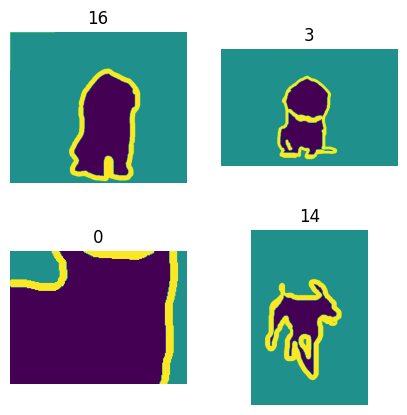

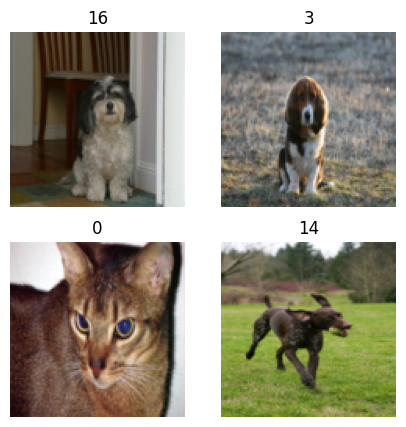

In [6]:
# Checking if input images & masks are coming as expected
x = 0
for images, labels, t_masks in train_loader:    
    plt.figure(figsize=(5, 5))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        t_mask = img.open(t_masks[i])
        t_mask_np = np.array(t_mask)
        print(t_mask_np.shape)
        plt.imshow((t_mask_np)/ 2 * 255)
        plt.title(int(labels[i]))
        plt.axis('off')
    plt.show()

    plt.figure(figsize=(5, 5))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(int(labels[i]))
        plt.axis('off')
    plt.show()
  
    x += 1
    if x > 0:
      break

In [7]:
class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractingBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
        #self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.stride  = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        skip = x  # store the output for the skip connection
        x = self.stride(x)
        
        return x, skip

class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpandingBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)       

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.less_channels = nn.Conv2d(out_channels, out_channels // 2, kernel_size=1)  
        self.combined_channels = out_channels + (out_channels // 2)
        self.out_channels = out_channels
        self.adjust = nn.Conv2d(self.combined_channels, out_channels, kernel_size=1)
        
    def forward(self, x, skip):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.upsample(x)
        x = self.less_channels(x)
       
        # concatenate the skip connection
        x = torch.cat((x, skip), dim=1)
        if self.out_channels != self.combined_channels:
            x = self.adjust(x)

        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.contract1 = ContractingBlock(in_channels, 64)
        self.contract2 = ContractingBlock(64, 128)
        self.contract3 = ContractingBlock(128, 256)
        self.contract4 = ContractingBlock(256, 512)
        
        self.expand1 = ExpandingBlock(512, 256)
        self.expand2 = ExpandingBlock(256, 128)
        self.expand3 = ExpandingBlock(128, 64)
        self.expand4 = ExpandingBlock(64, 32)
        
        self.upsample0 = nn.Upsample(scale_factor=2, mode='nearest')
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Contracting path
        x, skip1 = self.contract1(x)   # torch.Size([2, 64, 120, 120]) , torch.Size([2, 64, 240, 240])
        x, skip2 = self.contract2(x)   # torch.Size([2, 128, 60, 60]) , torch.Size([2, 128, 120, 120])
        x, skip3 = self.contract3(x)   # torch.Size([2, 256, 30, 30]) , torch.Size([2, 256, 60, 60])
        x, _     = self.contract4(x)   # torch.Size([2, 512, 15, 15])
        
        # Expanding path        
        x = self.upsample0(x)        
        x = self.expand1(x, skip3)                
        x = self.expand2(x, skip2)        
        x = self.expand3(x, skip1)        
        x = self.final_conv(x)        
        return x

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu


In [9]:
model = UNet(in_channels=3, out_channels=1).to(device)
summary(model, input_size=(3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          36,928
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
            Conv2d-7           [-1, 64, 56, 56]          36,928
  ContractingBlock-8  [[-1, 64, 56, 56], [-1, 64, 112, 112]]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 128, 56, 56]         147,584
      BatchNorm2d-13          [-1, 128, 56, 56]             256
             ReLU-14      

In [10]:
def dice_loss(pred, target):
    smooth = 1e-5
    
    # flatten predictions and targets
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return 1 - dice  

In [11]:
class train_losses():
    def __init__(self, model, device, train_loader, optimizer, total_epochs):
        self.model = model
        self.device = device
        self.train_loader = train_loader
        self.optimizer = optimizer
        self.total_epochs = total_epochs 
        self.convert_tensor = transforms.Compose([transforms.Resize((112, 112)),
                                                  transforms.ToTensor()])   
        self.loss = nn.BCEWithLogitsLoss() 

    def get_mask(self, mask_paths):
        lst = []
        for mask_path in mask_paths:
            mask = img.open(mask_path)
            t1 = self.convert_tensor(mask)
            lst.append(t1)
        t0 = torch.stack(lst, 0)
        return t0          

    def unet_train(self, current_epoch):
        self.model.train()
        pbar = tqdm(self.train_loader)
        train_loss, correct, processed = 0, 0, 0
        for batch_idx, (data, target, mask_paths) in enumerate(pbar):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(data)
            mask_gt = self.get_mask(mask_paths)
            mask_gt = mask_gt.to(self.device)
            train_loss = dice_loss(y_pred, mask_gt)

            train_loss.backward()
            self.optimizer.step()

            lr = 0
            lr = self.optimizer.param_groups[0]['lr']              

            pbar.set_description(desc=f'Loss={train_loss.item() :0.4f} Batch={batch_idx}')                       


        print(
            f'Train set: Epoch : {current_epoch+1}/{self.total_epochs} Average loss: {train_loss :.4f}')                    


In [12]:
class test_losses():
  def __init__(self, model, device, test_loader, total_epochs):
      self.model        = model
      self.device       = device
      self.test_loader  = test_loader
      self.total_epochs = total_epochs
      self.convert_tensor = transforms.Compose([transforms.Resize((112, 112)),
                                                  transforms.ToTensor()])  
      self.loss = nn.BCEWithLogitsLoss()      

  def get_mask(self, mask_paths):
      lst = []
      for mask_path in mask_paths:
          mask = img.open(mask_path)
          t1 = self.convert_tensor(mask)
          lst.append(t1)
      t0 = torch.stack(lst, 0)
      return t0        

  def unet_test(self, current_epoch):
      self.model.eval()
      test_loss, correct, count_wrong = 0, 0, 0
      with torch.no_grad():
          for data, target, mask_path in self.test_loader:
              data, target = data.to(self.device), target.to(self.device)
              output = self.model(data)
              mask_gt = self.get_mask(mask_path)
              mask_gt = mask_gt.to(self.device)
              test_loss += dice_loss(output, mask_gt)

      avg_loss = test_loss/len(self.test_loader.dataset)

      print(f'Test set: Epoch : {current_epoch+1}/{self.total_epochs} Average loss: {avg_loss :.4f}  test_loss : {test_loss :.4f} ')

In [ ]:
EPOCHS = 10
model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.003)
train = train_losses(model, device, train_loader, optimizer, EPOCHS)
test  = test_losses(model, device, test_loader, EPOCHS)

for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch}')
    train.unet_train(epoch)
    test.unet_test(epoch)

EPOCH: 0


  0%|          | 0/184 [00:00<?, ?it/s]

## Few basic validations to ensure that transforms of mask & images are not messing up & Displaying the predictions

In [ ]:
# Defined transforms
convert_tensor_nn = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor()])  

# Get original mask_size and a list of tensors which has the resized mask
def get_mask_size(mask_paths):
    resize_lst = []
    for test_mask_path in test_mask_paths:
        mask = img.open(test_mask_path)
        mask_t1 = convert_tensor_nn(mask)
        mask_np = np.array(mask_t1)
        resize_lst.append(mask_np)
    return resize_lst

# Calling the trained model with val_loader for 1 iteration
with torch.no_grad():
    i = 0
    for data, _, test_mask_paths in val_loader:
        resize_lst = get_mask_size(test_mask_paths)
        data = data.to(device)
        test_output = model(data)
        i += 1
        if i > 0:
           break

 Output shape : torch.Size([4, 1, 112, 112])
(500, 375) /content/OxfordIIITPet/annotations/trimaps/american_bulldog_132.png
(300, 274) /content/OxfordIIITPet/annotations/trimaps/pomeranian_167.png
(500, 333) /content/OxfordIIITPet/annotations/trimaps/Siamese_138.png
(275, 183) /content/OxfordIIITPet/annotations/trimaps/Maine_Coon_7.png


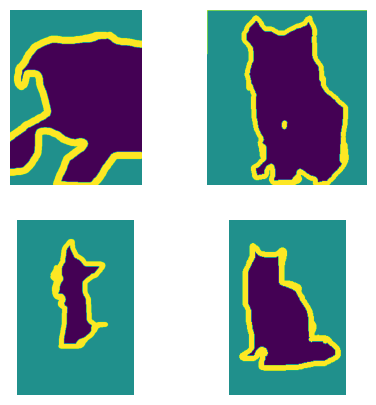

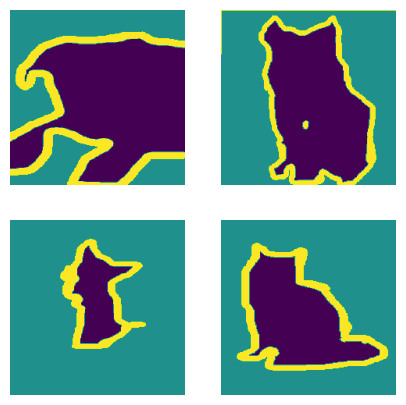

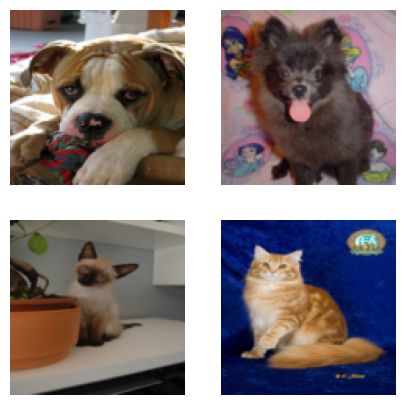

In [ ]:
print(f' Output shape : {test_output.shape}')
# Displaying the original input masks before resizing
plt.figure(figsize=(5, 5))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    mask = img.open(test_mask_paths[i])
    mask_np = np.array(mask)
    print(mask_np.shape, test_mask_paths[i])
    plt.imshow((mask_np)/ 2 * 255)
    plt.axis('off')
plt.show()

# Displaying the resized tensor input masks
plt.figure(figsize=(5, 5))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow((resize_lst[i]).squeeze(0)/ 2 * 255)
    plt.axis('off')
plt.show()

# Displaying the resized input images
plt.figure(figsize=(5, 5))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(data[i].detach().cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

torch.Size([4, 112, 112])
(4, 112, 112)


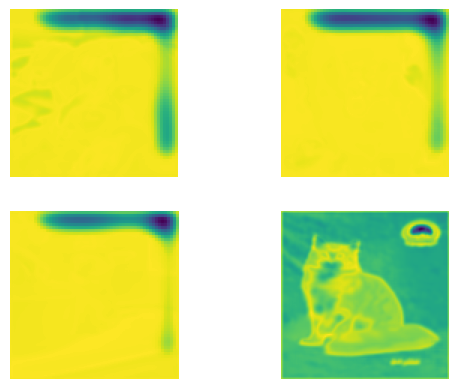

In [ ]:
# Removing the dimension from [4, 1, 224, 224] to [4, 224, 224]
new_out= test_output.squeeze(1)
print(new_out.shape)
np_arr = new_out.detach().cpu().numpy()
print(np_arr.shape)

# Displaying the predictions
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow((np_arr[i])/ 2 * 255)
    plt.axis('off')
plt.show()